<a href="https://colab.research.google.com/github/swap-mitra/deep-learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning in Image Classification

###In this notebook transfer learning is used and pre-trained model is taken from Google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand

##Author : Swapnil Mitra

#Imports

In [18]:
import numpy as np
import cv2

import PIL.Image as Image
import os
import pathlib

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

%matplotlib inline

# Getting the Data

In [ ]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))])

In [5]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


# Data Exploration

In [8]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [10]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('/root/.keras/datasets/flower_photos/roses/16152175716_55d6968e08_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/15761264350_4caaf080f6_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/2258973326_03c0145f15_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/6653567281_768a1fd160.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/9164900485_605aa12da8.jpg')]

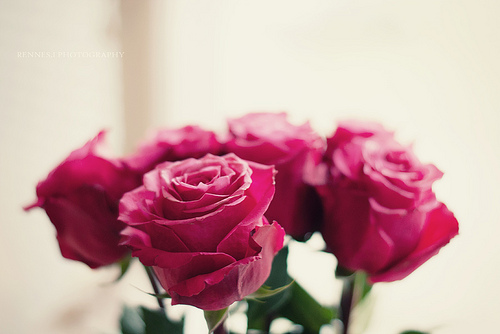

In [14]:
Image.open(str(roses[3]))

In [15]:
flower_image_dict = {
    'roses':list(data_dir.glob('roses/*')),
    'daisy':list(data_dir.glob('daisy/*')),
    'dandelion':list(data_dir.glob('dandelion/*')),
    'sunflowers':list(data_dir.glob('sunflowers/*')),
    'tulips':list(data_dir.glob('tulips/*')),
}

flower_labels_dict = {
    'roses':0,
    'daisy':1,
    'dandelion':2,
    'sunflowers':3,
    'tulips':4,
}

In [16]:
X,y = [], []

for flower_name, images in flower_image_dict.items():
  for image in images:
    img = cv2.imread(str(image))
    resized_img = cv2.resize(img,IMAGE_SHAPE)
    X.append(resized_img)
    y.append(flower_labels_dict[flower_name])

In [17]:
X = np.array(X)
y = np.array(y)

## Train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##Preprocessing: Scale images

In [20]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

#Now taking pre-trained model and retrain it using flowers images

In [22]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [23]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 74s 810ms/step - loss: 0.8512 - acc: 0.6770
Epoch 2/5
86/86 [==============================] - 70s 818ms/step - loss: 0.4392 - acc: 0.8452
Epoch 3/5
86/86 [==============================] - 71s 830ms/step - loss: 0.3425 - acc: 0.8837
Epoch 4/5
86/86 [==============================] - 71s 829ms/step - loss: 0.2849 - acc: 0.9153
Epoch 5/5
86/86 [==============================] - 71s 830ms/step - loss: 0.2446 - acc: 0.9248


In [25]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 24s 809ms/step - loss: 0.3359 - acc: 0.8845


[0.3358747363090515, 0.8845316171646118]